- scatter plot vs choi for test and controls
- checkerboard vs choi

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt

from ccsblib import paros_connection

In [157]:
qry = """
select plate, well, score
from tf_validation.prs_score
where batch = 'pilot220428';
"""
df = pd.read_sql(qry, paros_connection())
df = pd.concat([
    (df.loc[df['plate'].isin(['plate1', 'plate3', 'plate4']), :]
    .pivot_table(index='well', columns='plate', values='score')
    .reset_index()
    .rename(columns={'plate1': 'test_pilot220428', 'plate3': 'empty_F2_control_pilot220428', 'plate4': 'empty_F1_control_pilot220428'})
    .assign(plate=1)),
    (df.loc[df['plate'].isin(['plate2', 'plate5', 'plate6']), :]
    .pivot_table(index='well', columns='plate', values='score')
    .reset_index()
    .rename(columns={'plate2': 'test_pilot220428', 'plate5': 'empty_F2_control_pilot220428', 'plate6': 'empty_F1_control_pilot220428'})
    .assign(plate=2))
])

qry = """select a.plate, a.well, 
	   n1n2_r1 as test_Choi_r1, 
		n1f2_r1 as empty_F2_control_Choi_r1,
		f1n2_r1 as empty_F1_control_Choi_r1,
			   n1n2_r2 as test_Choi_r2, 
		n1f2_r2 as empty_F2_control_Choi_r2,
		f1n2_r2 as empty_F1_control_Choi_r2,
			   n1n2_r3 as test_Choi_r3, 
		n1f2_r3 as empty_F2_control_Choi_r3,
		f1n2_r3 as empty_F1_control_Choi_r3,
		 orf_ida, symbol_a, orf_idb, symbol_b, category
from n2h.mn2h_raw as a
left join n2h.mn2h_control_raw as b
on a.plate = b.plate
and a.well = b.well
inner join n2h.prsrrs as c
on a.plate = c.plate
and a.well = c.well
where c.is_v2 = 1;"""
choi = pd.read_sql(qry, paros_connection())
df = pd.merge(df, choi, how='inner')

qry = """select distinct ad_orf_id AS orf_ida, db_orf_id AS orf_idb, retest_pla, retest_pos, standard_batch, variant_id, db_source_plate, db_source_well, ad_source_plate, ad_source_well, N2H_raw_r01, N2H_raw_r02 
from vus.retest 
where standard_batch = "mN2Hapwtv2";"""
edge = pd.read_sql(qry, paros_connection())
edge = edge.loc[edge['ad_source_plate'].str.startswith('PRSRRS') | edge['db_source_plate'].str.startswith('PRSRRS'), :]
rows = []
for i in range(0, edge.shape[0], 3):
    rows.append({
    'orf_ida': edge.iloc[i, :]['orf_ida'],
    'orf_idb': edge.iloc[i, :]['orf_idb'],
    'test_edgotyping_r1': edge.iloc[i, :]['N2H_raw_r01'],
    'empty_F2_control_edgotyping_r1': edge.iloc[i+2, :]['N2H_raw_r01'],
    'empty_F1_control_edgotyping_r1': edge.iloc[i+1, :]['N2H_raw_r01'],
    'test_edgotyping_r2': edge.iloc[i, :]['N2H_raw_r02'],
    'empty_F2_control_edgotyping_r2': edge.iloc[i+2, :]['N2H_raw_r02'],
    'empty_F1_control_edgotyping_r2': edge.iloc[i+1, :]['N2H_raw_r02']}
    )
edge = pd.DataFrame(data=rows)
df = pd.merge(df, edge, how='inner', on=['orf_ida', 'orf_idb'])

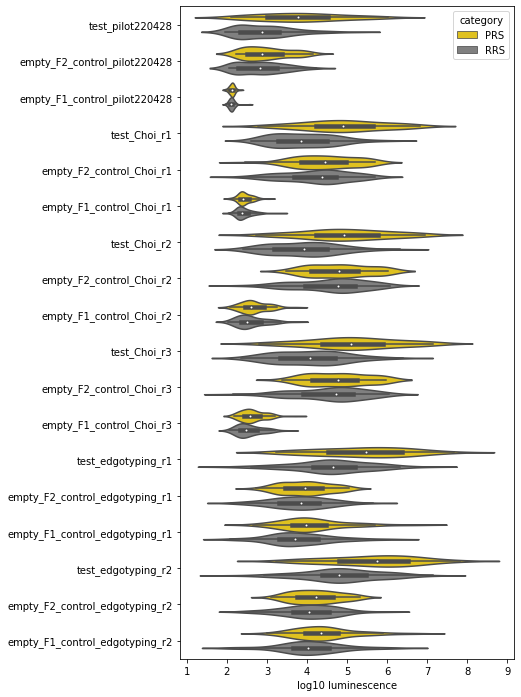

In [158]:
df_tmp = df.melt(id_vars=['symbol_a', 'symbol_b', 'category'],
                 value_vars=[c for c in df.columns if c.split('_')[0] in ['test', 'empty']])
df_tmp['log10 luminescence'] = np.log10(df_tmp['value'])
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=6, h=12)
sns.violinplot(data=df_tmp, x='log10 luminescence', y='variable', hue='category', palette=['gold', 'grey'], ax=ax)
ax.set_ylabel('')
fig.savefig('../../figures/pilot220428-vs-Choi-et-al-vs-edgotyping_raw-scores_violin.pdf',
            bbox_inches='tight')

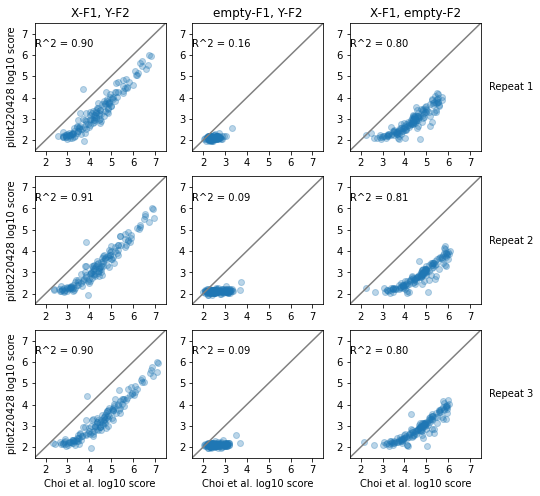

In [84]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(8, 8)
s_min = 1.5
s_max = 7.5
mid_point = (s_max-s_min)/2 + s_min
for repeat, ax_row in zip([1, 2, 3], axs):
    for test, ax in zip(['test', 'empty_F1_control', 'empty_F2_control'], ax_row):
        x = np.log10(df[f'{test}_Choi_r{repeat}'].values)
        y = np.log10(df[f'{test}_pilot220428'].values)
        ax.scatter(x=x, y=y, alpha=0.3)
        ax.plot([s_min, s_max], [s_min, s_max], color='grey')
        ax.set_ylim(s_min, s_max)
        ax.set_xlim(s_min, s_max)
        ax.set_yticks(range(2, 8))
        ax.set_xticks(range(2, 8))
        r2 = stats.pearsonr(x, y)[0] ** 2
        ax.text(x=s_min, y=s_max*0.85, s=f'R^2 = {r2:.2f}')
axs[0, 0].set_title('X-F1, Y-F2')
axs[0, 1].set_title('empty-F1, Y-F2')
axs[0, 2].set_title('X-F1, empty-F2')
axs[0, -1].text(s='Repeat 1', x=s_max * 1.05, y=mid_point, va='center', ha='left')
axs[1, -1].text(s='Repeat 2', x=s_max * 1.05, y=mid_point, va='center', ha='left')
axs[2, -1].text(s='Repeat 3', x=s_max * 1.05, y=mid_point, va='center', ha='left')
for ax in axs[-1, :]:
    ax.set_xlabel('Choi et al. log10 score')
for ax in axs[:, 0]:
    ax.set_ylabel('pilot220428 log10 score')
fig.savefig('../../figures/pilot220428-vs-Choi-et-al_scatter.pdf',
            bbox_inches='tight')

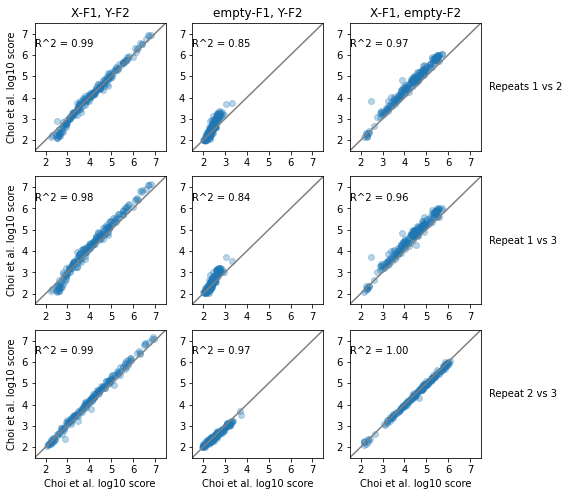

In [69]:
# Choi vs itself
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(8, 8)
s_min = 1.5
s_max = 7.5
mid_point = (s_max-s_min)/2 + s_min
for (repeat_x, repeat_y), ax_row in zip([(1, 2), (1, 3), (2, 3)], axs):
    for test, ax in zip(['test', 'empty_F1_control', 'empty_F2_control'], ax_row):
        x = np.log10(df[f'{test}_Choi_r{repeat_x}'].values)
        y = np.log10(df[f'{test}_Choi_r{repeat_y}'].values)
        ax.scatter(x=x, y=y, alpha=0.3)
        ax.plot([s_min, s_max], [s_min, s_max], color='grey')
        ax.set_ylim(s_min, s_max)
        ax.set_xlim(s_min, s_max)
        ax.set_yticks(range(2, 8))
        ax.set_xticks(range(2, 8))
        r2 = stats.pearsonr(x, y)[0] ** 2
        ax.text(x=s_min, y=s_max*0.85, s=f'R^2 = {r2:.2f}')
axs[0, 0].set_title('X-F1, Y-F2')
axs[0, 1].set_title('empty-F1, Y-F2')
axs[0, 2].set_title('X-F1, empty-F2')
axs[0, -1].text(s='Repeats 1 vs 2', x=s_max * 1.05, y=mid_point, va='center', ha='left')
axs[1, -1].text(s='Repeat 1 vs 3', x=s_max * 1.05, y=mid_point, va='center', ha='left')
axs[2, -1].text(s='Repeat 2 vs 3', x=s_max * 1.05, y=mid_point, va='center', ha='left')
for ax in axs[-1, :]:
    ax.set_xlabel('Choi et al. log10 score')
for ax in axs[:, 0]:
    ax.set_ylabel('Choi et al. log10 score')
fig.savefig('../../figures/Choi-et-al-vs-Choi-et-al_scatter.pdf',
            bbox_inches='tight')

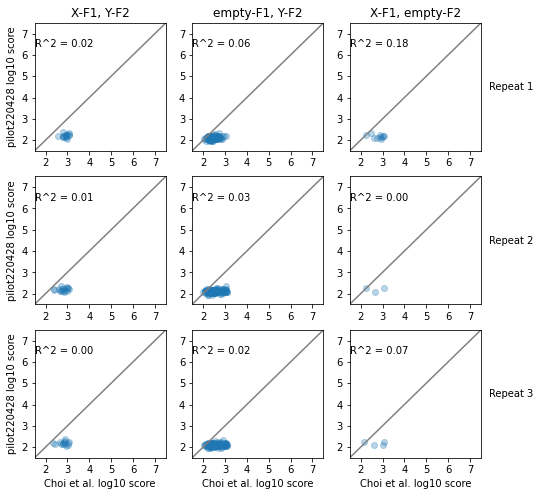

In [88]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(8, 8)
s_min = 1.5
s_max = 7.5
mid_point = (s_max-s_min)/2 + s_min
for repeat, ax_row in zip([1, 2, 3], axs):
    for test, ax in zip(['test', 'empty_F1_control', 'empty_F2_control'], ax_row):
        x = np.log10(df.loc[df[f'{test}_Choi_r{repeat}'] < 10**3.1, f'{test}_Choi_r{repeat}'].values)
        y = np.log10(df.loc[df[f'{test}_Choi_r{repeat}'] < 10**3.1, f'{test}_pilot220428'].values)
        ax.scatter(x=x, y=y, alpha=0.3)
        ax.plot([s_min, s_max], [s_min, s_max], color='grey')
        ax.set_ylim(s_min, s_max)
        ax.set_xlim(s_min, s_max)
        ax.set_yticks(range(2, 8))
        ax.set_xticks(range(2, 8))
        r2 = stats.pearsonr(x, y)[0] ** 2
        ax.text(x=s_min, y=s_max*0.85, s=f'R^2 = {r2:.2f}')
axs[0, 0].set_title('X-F1, Y-F2')
axs[0, 1].set_title('empty-F1, Y-F2')
axs[0, 2].set_title('X-F1, empty-F2')
axs[0, -1].text(s='Repeat 1', x=s_max * 1.05, y=mid_point, va='center', ha='left')
axs[1, -1].text(s='Repeat 2', x=s_max * 1.05, y=mid_point, va='center', ha='left')
axs[2, -1].text(s='Repeat 3', x=s_max * 1.05, y=mid_point, va='center', ha='left')
for ax in axs[-1, :]:
    ax.set_xlabel('Choi et al. log10 score')
for ax in axs[:, 0]:
    ax.set_ylabel('pilot220428 log10 score')
fig.savefig('../../figures/pilot220428-vs-Choi-et-al_scatter_restrict-lt-3.1.pdf',
            bbox_inches='tight')

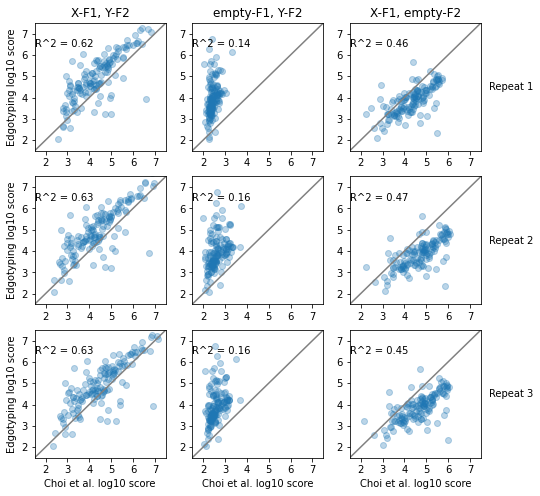

In [159]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(8, 8)
s_min = 1.5
s_max = 7.5
mid_point = (s_max-s_min)/2 + s_min
for repeat, ax_row in zip([1, 2, 3], axs):
    for test, ax in zip(['test', 'empty_F1_control', 'empty_F2_control'], ax_row):
        x = np.log10(df[f'{test}_Choi_r{repeat}'].values)
        y = np.log10(df[f'{test}_edgotyping_r1'].values)
        ax.scatter(x=x, y=y, alpha=0.3)
        ax.plot([s_min, s_max], [s_min, s_max], color='grey')
        ax.set_ylim(s_min, s_max)
        ax.set_xlim(s_min, s_max)
        ax.set_yticks(range(2, 8))
        ax.set_xticks(range(2, 8))
        r2 = stats.pearsonr(x, y)[0] ** 2
        ax.text(x=s_min, y=s_max*0.85, s=f'R^2 = {r2:.2f}')
axs[0, 0].set_title('X-F1, Y-F2')
axs[0, 1].set_title('empty-F1, Y-F2')
axs[0, 2].set_title('X-F1, empty-F2')
axs[0, -1].text(s='Repeat 1', x=s_max * 1.05, y=mid_point, va='center', ha='left')
axs[1, -1].text(s='Repeat 2', x=s_max * 1.05, y=mid_point, va='center', ha='left')
axs[2, -1].text(s='Repeat 3', x=s_max * 1.05, y=mid_point, va='center', ha='left')
for ax in axs[-1, :]:
    ax.set_xlabel('Choi et al. log10 score')
for ax in axs[:, 0]:
    ax.set_ylabel('Edgotyping log10 score')
fig.savefig('../../figures/pilot220428-vs-Choi-et-al-vs-edgotyping_scatter.pdf',
            bbox_inches='tight')

In [17]:
cutoff = {}
for experiment in ['pilot220428', 'Choi_r1', 'Choi_r2', 'Choi_r3']:
    df[f'nlr_{experiment}'] = np.log2(df[f'test_{experiment}'] / df[[f'empty_F1_control_{experiment}', f'empty_F2_control_{experiment}']].max(axis=1))
    cutoff[experiment] = df.loc[df['category'] == 'RRS', f'nlr_{experiment}'].max()
    df[f'result_{experiment}'] = df[f'nlr_{experiment}'] > cutoff[experiment]

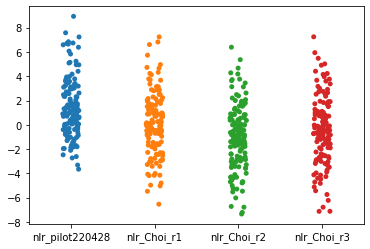

In [89]:
# horizontal dot plot
import seaborn as sns

cols = ['nlr_pilot220428', 'nlr_Choi_r1', 'nlr_Choi_r2', 'nlr_Choi_r3']
sns.stripplot(data=df.loc[:, cols])

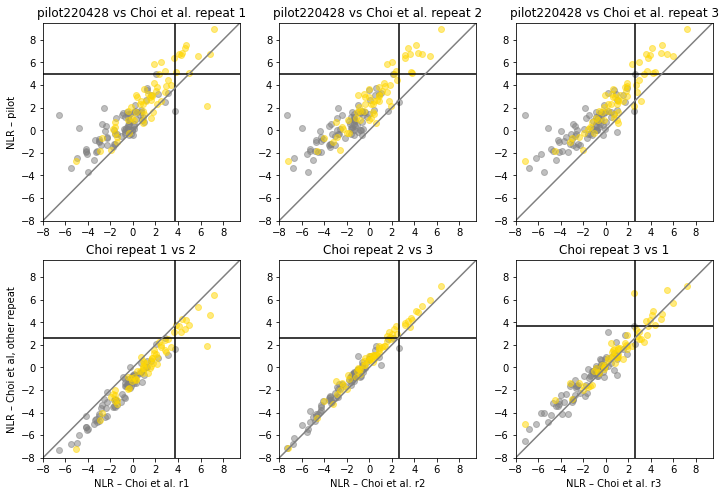

In [73]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(h=8, w=12)
nlr_max = 9.5
nlr_min = -8
for repeat, ax in zip(range(1, 4), axs[0]):
    ax.axvline(x=cutoff[f'Choi_r{repeat}'], color='black')
    ax.axhline(y=cutoff['pilot220428'], color='black')
    ax.scatter(x=df.loc[df['category'] == 'RRS', f'nlr_Choi_r{repeat}'],
               y=df.loc[df['category'] == 'RRS', 'nlr_pilot220428'],
               color='grey',
               alpha=0.5)
    ax.scatter(x=df.loc[df['category'] == 'PRS', f'nlr_Choi_r{repeat}'],
               y=df.loc[df['category'] == 'PRS', 'nlr_pilot220428'],
               color='gold',
               alpha=0.5)
    ax.set_title(f'pilot220428 vs Choi et al. repeat {repeat}')
for (rx, ry), ax in zip([(1, 2), (2, 3), (3, 1)], axs[1]):
    ax.axvline(x=cutoff[f'Choi_r{rx}'], color='black')
    ax.axhline(y=cutoff[f'Choi_r{ry}'], color='black')
    ax.scatter(x=df.loc[df['category'] == 'RRS', f'nlr_Choi_r{rx}'],
               y=df.loc[df['category'] == 'RRS', f'nlr_Choi_r{ry}'],
               color='grey',
               alpha=0.5)
    ax.scatter(x=df.loc[df['category'] == 'PRS', f'nlr_Choi_r{rx}'],
               y=df.loc[df['category'] == 'PRS', f'nlr_Choi_r{ry}'],
               color='gold',
               alpha=0.5)
    ax.set_title(f'Choi repeat {rx} vs {ry}')
    ax.set_xlabel(f'NLR – Choi et al. r{rx}')
for ax in axs.flatten():
    ax.plot([nlr_min, nlr_max], [nlr_min, nlr_max], color='grey')
    ax.set_xlim(nlr_min, nlr_max)
    ax.set_ylim(nlr_min, nlr_max)
    ticks = range(nlr_min, int(nlr_max) + 1, 2)
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
axs[0, 0].set_ylabel('NLR – pilot')
axs[1, 0].set_ylabel('NLR – Choi et al, other repeat')
fig.savefig('../../figures/pilot220428-vs-Choi-et-al_NLR_scatter.pdf',
            bbox_inches='tight')

In [61]:
from ccsblib.ccsbplotlib import checkerboard

In [63]:
pd.set_option('display.max_columns', 100)
df.head()

,well,test_pilot220428,empty_F2_control_pilot220428,empty_F1_control_pilot220428,plate,test_Choi_r1,empty_F2_control_Choi_r1,empty_F1_control_Choi_r1,test_Choi_r2,empty_F2_control_Choi_r2,empty_F1_control_Choi_r2,test_Choi_r3,empty_F2_control_Choi_r3,empty_F1_control_Choi_r3,orf_ida,symbol_a,orf_idb,symbol_b,category,nlr_pilot220428,result_pilot220428,nlr_Choi_r1,result_Choi_r1,nlr_Choi_r2,result_Choi_r2,nlr_Choi_r3,result_Choi_r3
0,A01,27970,5453,137,1,451586,284555,373,599322,758302,427,749721,653100,345,1108,LCP2,5001,NCK1,PRS,2.358758,False,0.666293,False,-0.339441,False,0.199050,False
1,A02,3228,3585,144,1,21407,34787,261,23227,47024,287,39366,19897,278,273,FKBP3,5046,NQO2,RRS,-0.151333,False,-0.700466,False,-1.017594,False,0.984399,False
2,A04,735,268,130,1,17071,8553,269,16574,12498,399,22626,13199,390,2403,ORC2,8578,MCM10,PRS,1.455511,False,0.997045,False,0.407225,False,0.777553,False
3,A05,185,295,151,1,1769,12207,213,1882,30012,224,2671,21596,219,8536,BDNF,636,NTF4,PRS,-0.673190,False,-2.786703,False,-3.995201,False,-3.015312,False
4,A06,577,179,130,1,7225,179,553,7099,185,2225,9447,143,1613,2877,RGR,6034,ABCF3,RRS,1.688612,False,3.707646,False,1.673810,False,2.550110,False


In [72]:
cutoff

{'pilot220428': 4.944208733358151,
 'Choi_r1': 3.7076462020406966,
 'Choi_r2': 2.622700378012034,
 'Choi_r3': 2.644621002941189}

In [183]:
df.loc[df['category'] == 'PRS',
       ['result_pilot220428', 'result_Choi_r1', 'result_Choi_r2', 'result_Choi_r3']].sum()

KeyError: "None of [Index(['result_pilot220428', 'result_Choi_r1', 'result_Choi_r2',\n       'result_Choi_r3'],\n      dtype='object')] are in the [columns]"

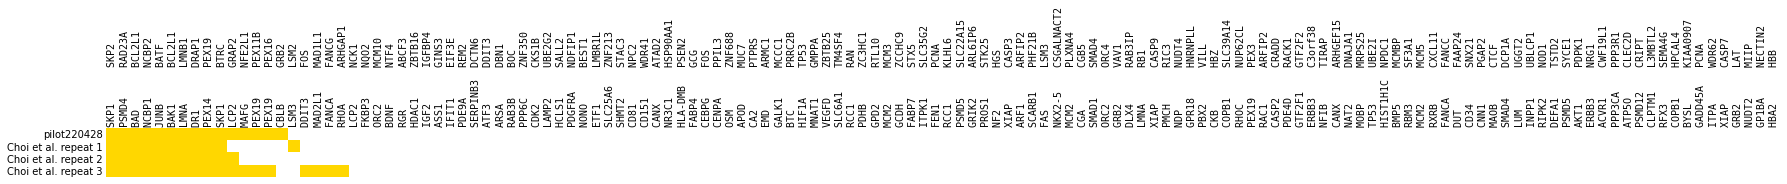

In [79]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(h=4, w=30)
checkerboard(data=df,
             protein_a_column='symbol_a',
             protein_b_column='symbol_b',
             detection_columns=['result_pilot220428', 'result_Choi_r1', 'result_Choi_r2', 'result_Choi_r3'],
             assay_labels=['pilot220428', 'Choi et al. repeat 1', 'Choi et al. repeat 2', 'Choi et al. repeat 3'],
             positive_color='gold',
             ax=ax)
fig.savefig('../../figures/pilot220428-vs-Choi-et-al_checkerboard.pdf',
            bbox_inches='tight')

KeyError: "None of [Index(['result_pilot220428', 'result_Choi_r1', 'result_Choi_r2',\n       'result_Choi_r3', 'result_edgotyping_r1', 'result_edgotyping_r2'],\n      dtype='object')] are in the [columns]"

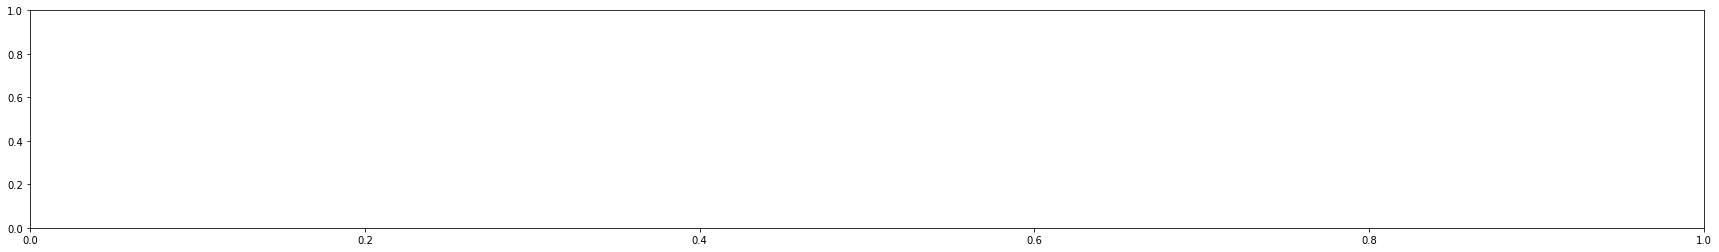

In [182]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(h=4, w=30)
checkerboard(data=df,
             protein_a_column='symbol_a',
             protein_b_column='symbol_b',
             detection_columns=['result_pilot220428', 'result_Choi_r1', 'result_Choi_r2', 'result_Choi_r3', 'result_edgotyping_r1', 'result_edgotyping_r2'],
             assay_labels=['pilot220428', 'Choi et al. repeat 1', 'Choi et al. repeat 2', 'Choi et al. repeat 3', 'VUS repeat 1', 'VUS repeat 2'],
             positive_color='gold',
             ax=ax)
fig.savefig('../../figures/pilot220428-vs-Choi-et-al-vs-edgotyping_checkerboard.pdf',
            bbox_inches='tight')

In [160]:
df.head()

,well,test_pilot220428,empty_F2_control_pilot220428,empty_F1_control_pilot220428,plate,test_Choi_r1,empty_F2_control_Choi_r1,empty_F1_control_Choi_r1,test_Choi_r2,empty_F2_control_Choi_r2,empty_F1_control_Choi_r2,test_Choi_r3,empty_F2_control_Choi_r3,empty_F1_control_Choi_r3,orf_ida,symbol_a,orf_idb,symbol_b,category,test_edgotyping_r1,empty_F2_control_edgotyping_r1,empty_F1_control_edgotyping_r1,test_edgotyping_r2,empty_F2_control_edgotyping_r2,empty_F1_control_edgotyping_r2
0,A01,27970,5453,137,1,451586,284555,373,599322,758302,427,749721,653100,345,1108,LCP2,5001,NCK1,PRS,2.289505e+06,72157.333333,133281.333333,3.670188e+06,106002.333333,207970.666667
1,A02,3228,3585,144,1,21407,34787,261,23227,47024,287,39366,19897,278,273,FKBP3,5046,NQO2,RRS,5.132370e+05,64519.000000,27121.333333,8.464307e+05,77501.666667,58242.000000
2,A04,735,268,130,1,17071,8553,269,16574,12498,399,22626,13199,390,2403,ORC2,8578,MCM10,PRS,2.463033e+04,7763.000000,21398.666667,5.929167e+04,16582.666667,22600.000000
3,A05,185,295,151,1,1769,12207,213,1882,30012,224,2671,21596,219,8536,BDNF,636,NTF4,PRS,5.782000e+03,10059.666667,1635.333333,1.147833e+04,11064.666667,4576.666667
4,A06,577,179,130,1,7225,179,553,7099,185,2225,9447,143,1613,2877,RGR,6034,ABCF3,RRS,3.864833e+04,1707.000000,16142.666667,6.118700e+04,1127.666667,34426.000000


In [181]:
a = 'LMNA'
b = 'LMNB1'
p = (df['symbol_a'] == a) & (df['symbol_b'] == b)
np.log(df.loc[p, ''] / 

,well,test_pilot220428,empty_F2_control_pilot220428,empty_F1_control_pilot220428,plate,test_Choi_r1,empty_F2_control_Choi_r1,empty_F1_control_Choi_r1,test_Choi_r2,empty_F2_control_Choi_r2,empty_F1_control_Choi_r2,test_Choi_r3,empty_F2_control_Choi_r3,empty_F1_control_Choi_r3,orf_ida,symbol_a,orf_idb,symbol_b,category,test_edgotyping_r1,empty_F2_control_edgotyping_r1,empty_F1_control_edgotyping_r1,test_edgotyping_r2,empty_F2_control_edgotyping_r2,empty_F1_control_edgotyping_r2
69,A02,223561,2314,130,2,3804403,71316,233,5641642,136445,331,8108519,131563,359,3903,LMNA,2370,LMNB1,PRS,8520.666667,7106.333333,1774.5,12525.666667,15694.0,2396.666667


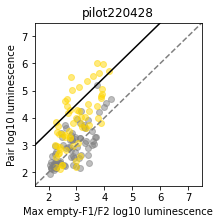

In [177]:
# NLR plot
s_min = 1.5
s_max = 7.5
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 3)
ax.scatter(x=np.log10(df.loc[df['category'] == 'RRS', ['empty_F1_control_pilot220428', 'empty_F2_control_pilot220428']].max(axis=1)),
           y=np.log10(df.loc[df['category'] == 'RRS', 'test_pilot220428']),
           color='grey',
           alpha=0.5)
ax.scatter(x=np.log10(df.loc[df['category'] == 'PRS', ['empty_F1_control_pilot220428', 'empty_F2_control_pilot220428']].max(axis=1)),
           y=np.log10(df.loc[df['category'] == 'PRS', 'test_pilot220428']),
           color='gold',
           alpha=0.5)
ax.set_xlim(s_min, s_max)
ax.set_ylim(s_min, s_max)
ax.plot([s_min, s_max],
        [s_min + np.log10(2 ** cutoff['pilot220428']), s_max + np.log10(2 ** cutoff['pilot220428'])],
        color='black')
ax.plot([s_min, s_max],
        [s_min, s_max],
        color='grey',
        linestyle='--')
ax.set_xticks(range(int(s_min) + 1, int(s_max) + 1))
ax.set_yticks(range(int(s_min) + 1, int(s_max) + 1))
ax.set_title('pilot220428')
ax.set_xlabel('Max empty-F1/F2 log10 luminescence')
ax.set_ylabel('Pair log10 luminescence')
fig.savefig('../../figures/pilot220428_max-control-vs-test-pair_scatter.pdf',
            bbox_inches='tight')